In [2]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import VotingRegressor
from sklearn.ensemble import StackingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error,mean_absolute_percentage_error
import pandas as pd
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout,GRU, LSTM, Bidirectional
import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import matplotlib
import math
from datetime import datetime
import yfinance as yf
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from alpha_vantage.timeseries import TimeSeries

In [3]:

import yfinance

def get_historical(quote):
    end = datetime.now()
    start = datetime(end.year - 2, end.month, end.day)
    data = yfinance.download(quote, start=start, end=end)
    df = pd.DataFrame(data=data)
    df.to_csv("" + quote + ".csv")
    if df.empty:
        ts = TimeSeries(key="dj0yJmk9WVJxNlRuYlZ3TXVjJmQ9WVdrOU1HSTNaMDVFZUZrbWNHbzlNQT09JnM9Y29uc3VtZXJzZWNyZXQmc3Y9MCZ4PWQ1", output_format="pandas")
        data= ts.get_daily_adjusted(symbol="NSE:" + quote, outputsize="full")
        data = data.head(503).iloc[::-1]
        data = data.reset_index()
        df = pd.DataFrame()
        df["Date"] = data["date"]
        df["Open"] = data["1. open"]
        df["High"] = data["2. high"]
        df["Low"] = data["3. low"]
        df["Close"] = data["4. close"]
        df["Adj Close"] = data["5. adjusted close"]
        df["Volume"] = data["6. volume"]
        df.to_csv("" + quote + ".csv", index=False)
    return

[*********************100%%**********************]  1 of 1 completed


C:\Users\ZUBAIR\AppData\Local\Temp\ipykernel_20124\2682774351.py:4: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  data = pd.read_csv('AAPL.csv', sep=',', parse_dates=['Date'], index_col='Date', date_parser=dateparse)


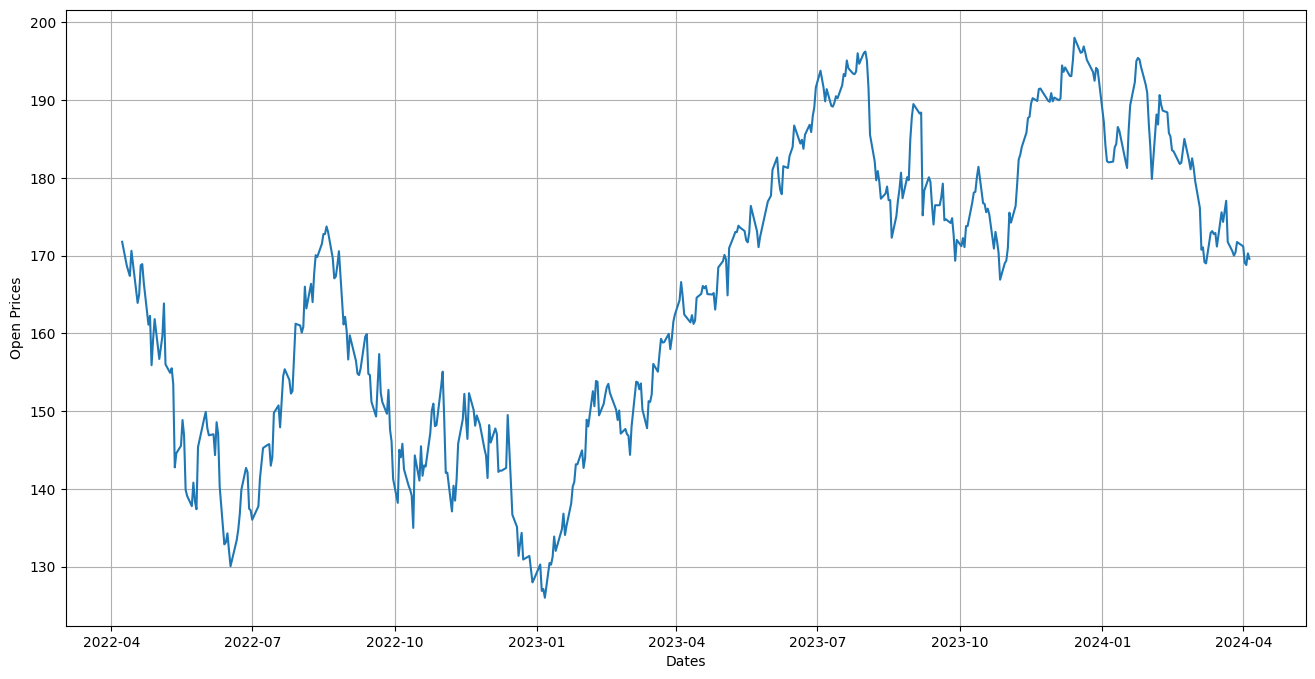

In [6]:
nm = input()
get_historical(nm)
dateparse = lambda dates: pd.to_datetime(dates, format='%Y-%m-%d')
data = pd.read_csv('AAPL.csv', sep=',', parse_dates=['Date'], index_col='Date', date_parser=dateparse)
plt.figure(figsize=(16,8))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Open Prices')
plt.plot(data['Open'])

# Model Building 

C:\Users\ZUBAIR\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1625: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


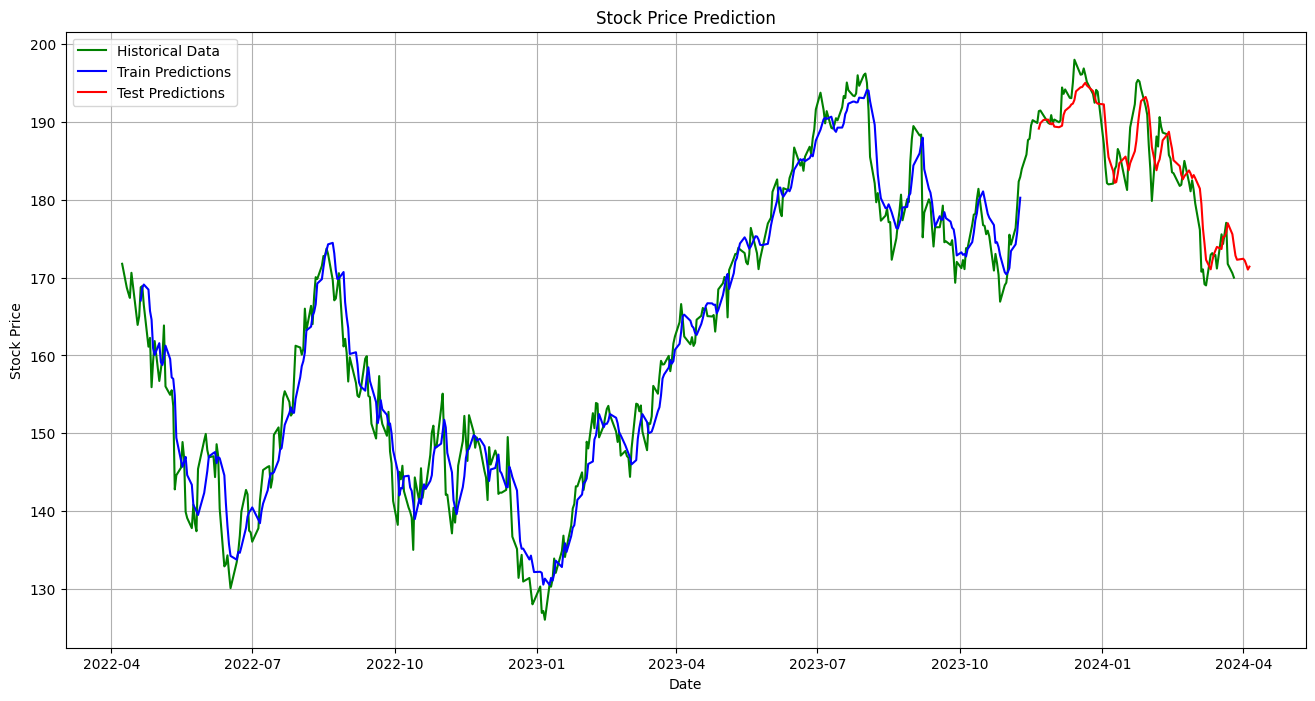

Accuracy: 98.9247311827957
Tomorrow's predicted stock price: 171.21841465890034
 MLP Training MSE: 11.857994902300987
MLP Testing MSE: 10.11802296220343
MLP Training MAE: 2.7251994257782
MLP Testing MAE: 2.567974000952905
MLP Training RMSE: 3.4435439451676797
MLP Testing RMSE: 3.1808839906861475


In [11]:
#MLP
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data[['Open']])
split = int(0.8 * len(scaled_data))
train_data = scaled_data[:split]
test_data = scaled_data[split:]
# Define sequences
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])
        y.append(data[i + seq_length])
    return np.array(X), np.array(y)
# Define sequence length
seq_length = 7

# Create sequences
X_train, y_train = create_sequences(train_data, seq_length)
X_test, y_test = create_sequences(test_data, seq_length)

# Reshape input data to 2D
X_train = X_train.reshape(X_train.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)

# Define and train MLP model
mlp = MLPRegressor(hidden_layer_sizes=(100, 50), activation='relu', solver='adam', random_state=1, max_iter=500)
mlp.fit(X_train, y_train)

# Make predictions
train_predictions = mlp.predict(X_train)
test_predictions = mlp.predict(X_test)

# Inverse transform predictions
train_predictions = scaler.inverse_transform(train_predictions.reshape(-1, 1))
y_train = scaler.inverse_transform(y_train.reshape(-1, 1))
test_predictions = scaler.inverse_transform(test_predictions.reshape(-1, 1))
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))

# Plot results
plt.figure(figsize=(16, 8))
plt.plot(data.index[:-seq_length], data['Open'][:-seq_length], color='green', label='Historical Data')
plt.plot(data.index[seq_length:split], train_predictions, color='blue', label='Train Predictions')
plt.plot(data.index[split+seq_length:split+seq_length+len(test_predictions)], test_predictions, color='red', label='Test Predictions')
plt.title('Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.grid(True)
plt.show()


# Evaluate performance
mlp_train_mse = mean_squared_error(y_train, train_predictions)
mlp_test_mse = mean_squared_error(y_test, test_predictions)
mlp_train_mae = mean_absolute_error(y_train, train_predictions)
mlp_test_mae = mean_absolute_error(y_test, test_predictions)
mlp_train_rmse = np.sqrt(mlp_train_mse)
mlp_test_rmse = np.sqrt(mlp_test_mse)

# Define a threshold percentage for accuracy
threshold_percentage = 0.05  # 5% threshold

# Calculate the difference between predictions and true values
difference = np.abs(test_predictions - y_test)

# Count the number of correct predictions based on the threshold
num_correct = np.sum(difference <= threshold_percentage * y_test)

# Calculate accuracy
accuracy = (num_correct / len(y_test))*100

print('Accuracy:', accuracy)
# Get the last sequence of data
last_sequence = scaled_data[-seq_length:]

# Reshape the sequence for prediction
last_sequence = last_sequence.reshape(1, -1)

# Make the prediction for tomorrow
tomorrow_prediction = mlp.predict(last_sequence)

# Inverse transform the prediction to get the actual price
tomorrow_prediction = scaler.inverse_transform(tomorrow_prediction.reshape(-1, 1))

print('Tomorrow\'s predicted stock price:', tomorrow_prediction[0][0])



print('MLP Training MSE:', mlp_train_mse)
print('MLP Testing MSE:', mlp_test_mse)
print('MLP Training MAE:', mlp_train_mae)
print('MLP Testing MAE:', mlp_test_mae)
print('MLP Training RMSE:', mlp_train_rmse)
print('MLP Testing RMSE:', mlp_test_rmse)

VOTING

C:\Users\ZUBAIR\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\ensemble\_voting.py:604: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\ZUBAIR\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


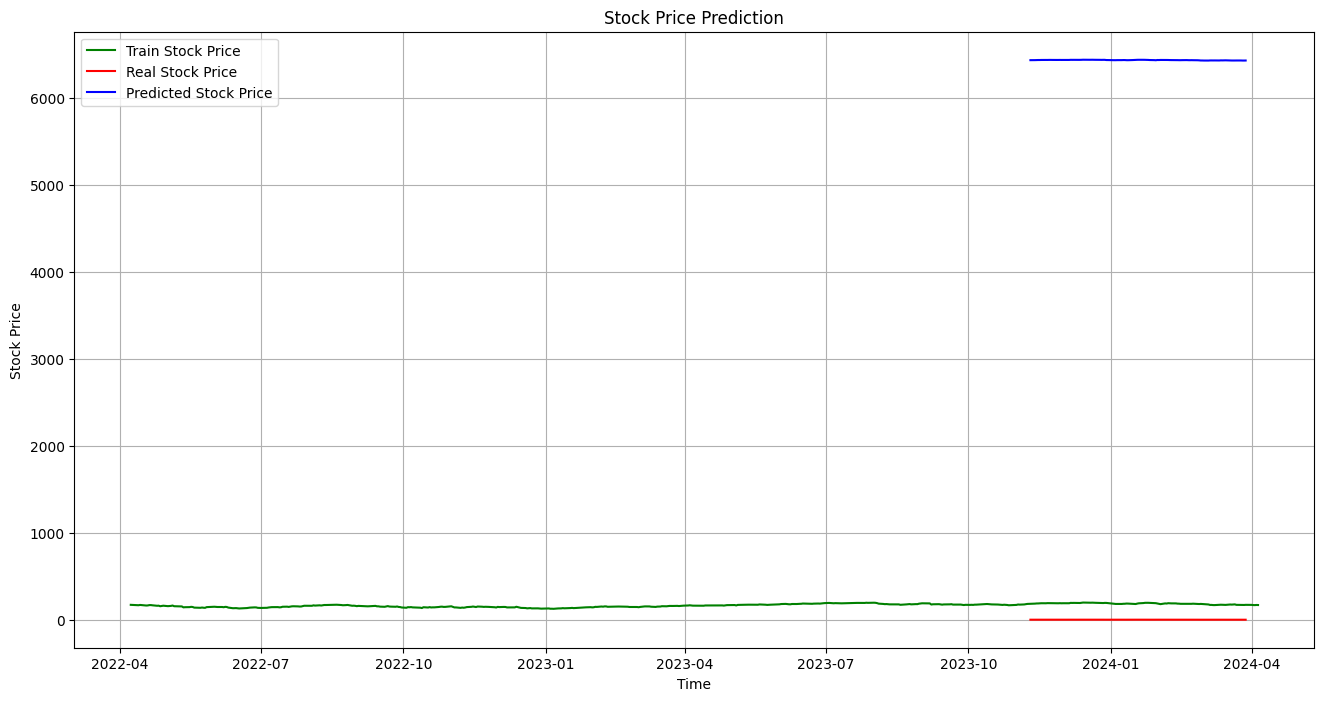

MSE: 41445429.20368905
MAE: 6437.81191652994
RMSE: 6437.812454839692


In [17]:
regressor1 = RandomForestRegressor()
regressor2 = GradientBoostingRegressor()
regressor3 = LinearRegression()

# Create a voting regressor
voting_regressor = VotingRegressor(estimators=[('rf', regressor1), ('gb', regressor2), ('lr', regressor3)])

# Fit the ensemble model
voting_regressor.fit(X_train, y_train)

# Make predictions
timesteps = 7
real_stock_price = test_data[:, 0]  # Extracting the first column directly from the NumPy array

# Prepare test inputs
combine = np.concatenate((train_data[:, 0], test_data[:, 0]), axis=0)
test_inputs = combine[len(combine) - len(test_data) - timesteps:]
test_inputs = test_inputs.reshape(-1, 1)
test_inputs = scaler.transform(test_inputs)

X_test = []
for i in range(timesteps, test_data.shape[0] + timesteps):
    X_test.append(test_inputs[i - timesteps:i, 0])

X_test = np.array(X_test)

# Make predictions with the voting regressor
predicted_stock_price = voting_regressor.predict(X_test)

# Inverse transform predictions
predicted_stock_price = scaler.inverse_transform(predicted_stock_price.reshape(-1, 1))

# Plot results
plt.figure(figsize=(16, 8))
plt.plot(data.index[-600:], data['Open'].tail(600), color='green', label='Train Stock Price')

# Create date range for the test period
# test_index = pd.date_range(start=data.index[-len(real_stock_price)], periods=len(real_stock_price), freq='B')

plt.plot(test_index, real_stock_price, color='red', label='Real Stock Price')
plt.plot(test_index, predicted_stock_price, color='blue', label='Predicted Stock Price')
plt.title('Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.grid(True)
plt.show()


# Evaluate performance
mse_voting = mean_squared_error(real_stock_price, predicted_stock_price)
mae_voting = mean_absolute_error(real_stock_price, predicted_stock_price)
rmse_voting = math.sqrt(mse_voting)

print('MSE:', mse_voting)
print('MAE:', mae_voting)
print('RMSE:', rmse_voting)
